# Nested_Model_test
A test to see if numpyro can nest models inside one another.  
Conclusion: yes

In [4]:
import jax
import jax.numpy as jnp
import numpyro
import numpy as np
from numpyro import infer, distributions
from chainconsumer import ChainConsumer
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
numpyro.set_host_device_count(1)
jax.config.update('jax_platform_name', 'cpu')

Create an outer model and an inner model:

In [5]:
def outer_model():
    x = numpyro.sample('x', numpyro.distributions.Normal(0,1))
    inner_model()
    
def inner_model():
    y = numpyro.sample('y', numpyro.distributions.Normal(1,2))

Make a simple sampler and fire it off in the normal way:

In [6]:
print("Beginning sampling...")
sampler = numpyro.infer.MCMC(
    infer.NUTS(model = outer_model, init_strategy=infer.init_to_uniform()),
    num_warmup=100,
    num_samples=20000,
    num_chains=1,
    progress_bar=False,
    chain_method = 'sequential',
)
sampler.run(jax.random.PRNGKey(10))
print("Done")


Beginning sampling...
Done


Retrieve in chainconsumer and plot as per normal:

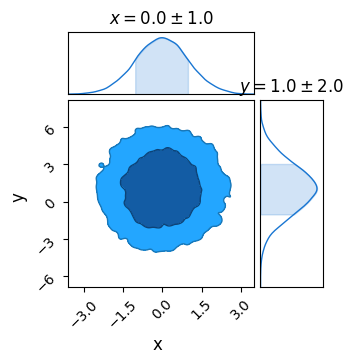

In [7]:
output = sampler.get_samples()
c = ChainConsumer()
c.add_chain([output['x'],output['y']], parameters=['x','y'])
c.plotter.plot()
plt.show()

Repeat the above, but instead of nesting, apply prior factors as functions. Note that we need the first prior, from which the entire distribution is drawn, to return the 'x' and 'y' values such that we can pass them to the constraining conditions:

In [62]:
def base_model():
    x = numpyro.sample('x', numpyro.distributions.Uniform(-1,1))
    y = numpyro.sample('y', numpyro.distributions.Uniform(-1,1))
    return(x,y)

def prior1(x,y):
    numpyro.sample('diffband', numpyro.distributions.Normal(0,0.25), obs=abs(x-y))
    return(x,y)
    
def prior2(x,y):
    numpyro.sample('xprior', numpyro.distributions.Normal(0,0.5), obs=x)
    numpyro.sample('yprior', numpyro.distributions.Normal(0,0.5), obs=y)
    return(x,y)

#------------------------

def model():
    x,y=base_model()
    prior1(x,y)
    prior2(x,y)

In [63]:
print("Beginning sampling...")
sampler = numpyro.infer.MCMC(
    infer.NUTS(model = model, init_strategy=infer.init_to_uniform()),
    num_warmup=100,
    num_samples=20000,
    num_chains=1,
    progress_bar=False,
    chain_method = 'sequential',
)
sampler.run(jax.random.PRNGKey(10))
print("Done")

Beginning sampling...
Done


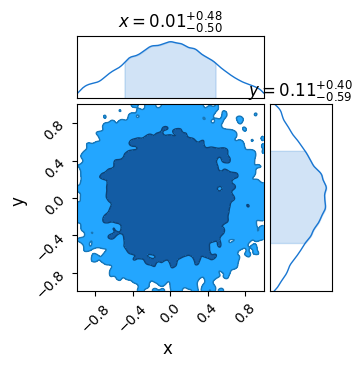

In [64]:
output = sampler.get_samples()
c = ChainConsumer()
c.add_chain([output['x'],output['y']], parameters=['x','y'])
c.plotter.plot()
plt.show()